# **QAI Agents Framework**

## QAI Agents Framework Demo (Colab)

**Job submitted**: `job_3c796f8f` (maturity=Prototype)

**Policy rule applied**: `{'allow_qpu': True, 'allow_simulator': True, 'qpu_budget_shots': 2000}`

**Planner decomposed job into** `2` subtasks: `['auto_circuit', 'hybrid_loop']`

### Executing subtask `44304800-4a0d-4be4-be4a-be46cb7b6536` (auto_circuit)

- AutoCircuit proposed ansatz: `{'name': 'HVA-like', 'depth': 6, 'params': [0.9560358788058699, 0.5990921234970467, 0.672157155814246, 0.6422903743865035, 0.7622052905191605, 0.16404250402676335, 0.05644283378063142, 0.9880333191856263, 0.49543826552921777, 0.5879244072667494, 0.46011994953413005, 0.7984949090154075], 'notes': 'dummy ansatz'}`

### Executing subtask `2160b37a-6e08-4c06-b8d5-343ffa518b80` (hybrid_loop)

- Hybrid loop using ansatz: `{'name': 'HVA-like', 'depth': 6, 'params': [0.1, 0.2, 0.3]}`

- Simulation Sandbox rollouts → mean: `0.3967`, std: `0.0456`

- Selected backend: `internal_qai`

- QPU result mean: `0.5399` shots: `1024` backend: `internal_qai`

**QCA Agent decision**: `{'agent': 'qca_1', 'backend_used': 'internal_qai', 'decision': 'reject', 'qpu_result_mean': 0.8600119398755718}`

**Aggregated artifact saved to**: `/content/qai_demo_artifacts/job_3c796f8f.json`

### Subtasks Summary

,task_id,type,assigned_agent,result_mean,result_shots,result_backend
0,44304800-4a0d-4be4-be4a-be46cb7b6536,auto_circuit,auto_circuit_service,NaN,NaN,None
1,2160b37a-6e08-4c06-b8d5-343ffa518b80,hybrid_loop,qpu_broker:internal_qai,0.539893,1024.0,internal_qai


### Pipeline Logs (sample)

,time_human,component,event,details
0,2025-09-22 06:18:18,WebService/API Gateway,Job received,job_id=job_3c796f8f
1,2025-09-22 06:18:20,Auth/ID Verification,ID verified,user_id=vijay
2,2025-09-22 06:18:21,RAG,KB retrieval,retrieved docs for 'optimization'
3,2025-09-22 06:18:23,Crew/Planner,Plan created,2 subtasks
4,2025-09-22 06:18:27,AutoCircuit,Ansatz proposed,auto_circuit by auto_circuit_service
5,2025-09-22 06:18:29,SimulationSandbox,Rollouts executed,scenarios=20
6,2025-09-22 06:18:32,QPU Broker,Backend selected,backend=simulator
7,2025-09-22 06:18:35,QPU Broker,Job submitted,shots=0
8,2025-09-22 06:18:27,AutoCircuit,Ansatz proposed,hybrid_loop by auto_circuit_service
9,2025-09-22 06:18:29,SimulationSandbox,Rollouts executed,scenarios=20


### Runtime KPIs (sample)

,time,queue_length,avg_latency_s,qpu_queue_wait_s
0,2025-09-22 06:18:18,1,0.648,6.57
1,2025-09-22 06:18:20,1,0.436,3.26
2,2025-09-22 06:18:22,1,0.190,4.62
3,2025-09-22 06:18:24,2,0.400,4.54
4,2025-09-22 06:18:26,1,0.548,4.24
5,2025-09-22 06:18:28,0,0.568,2.13
6,2025-09-22 06:18:30,0,0.621,7.30
7,2025-09-22 06:18:32,0,0.663,2.06
8,2025-09-22 06:18:34,1,0.505,4.75
9,2025-09-22 06:18:36,1,0.403,4.34


### Internal Products (initialized)

,product,id,status,notes,version,nodes,location,available_nodes,cooling
0,QAI_Processor,QAI-PROC-01,available,Dummy internal processor - low-latency,NaN,NaN,NaN,NaN,NaN
1,QAI_OS,NaN,deployed,NaN,0.1.0-dummy,2,NaN,NaN,NaN
2,QAI_Datacenter,NaN,NaN,NaN,NaN,NaN,On-Prem Lab,4,OK


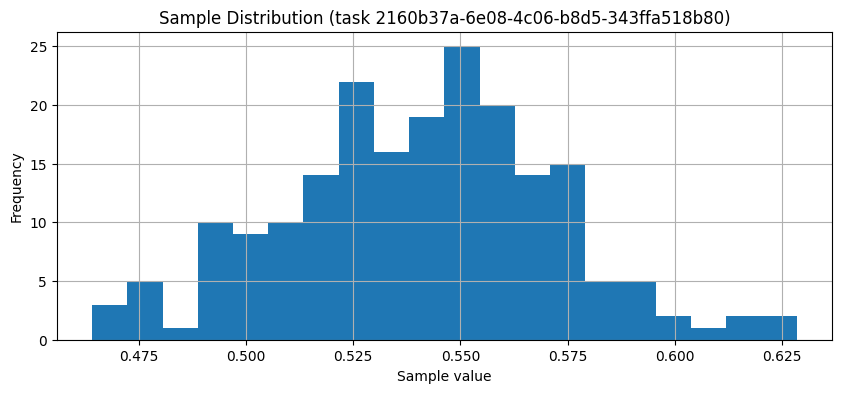

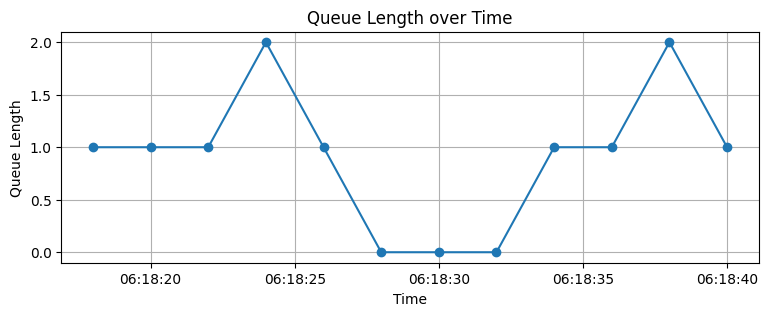

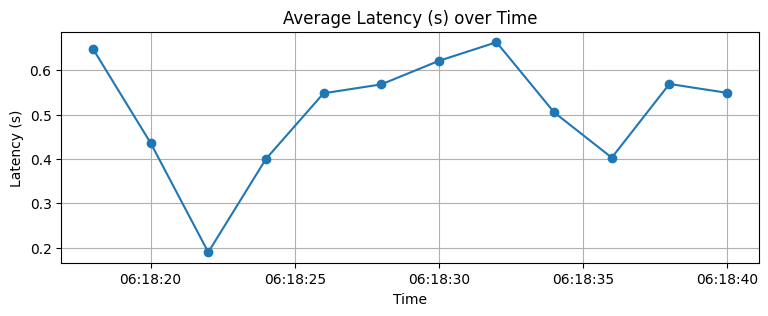

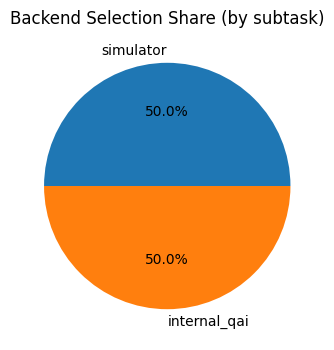

### End-to-end Trace (simulated)

,step_time,component,event,details
0,2025-09-22 06:18:18,WebService/API Gateway,Job received,job_id=job_3c796f8f
1,2025-09-22 06:18:20,Auth/ID Verification,ID verified,user_id=vijay
2,2025-09-22 06:18:21,RAG,KB retrieval,retrieved docs for 'optimization'
3,2025-09-22 06:18:23,Crew/Planner,Plan created,2 subtasks
4,2025-09-22 06:18:27,AutoCircuit,Ansatz proposed,auto_circuit by auto_circuit_service
5,2025-09-22 06:18:29,SimulationSandbox,Rollouts executed,scenarios=20
6,2025-09-22 06:18:32,QPU Broker,Backend selected,backend=simulator
7,2025-09-22 06:18:35,QPU Broker,Job submitted,shots=0
8,2025-09-22 06:18:27,AutoCircuit,Ansatz proposed,hybrid_loop by auto_circuit_service
9,2025-09-22 06:18:29,SimulationSandbox,Rollouts executed,scenarios=20


### KPI Summary

,total_subtasks,total_backends_used,avg_qpu_shots,artifact_path
0,2,2,512.0,/content/qai_demo_artifacts/job_3c796f8f.json


**Demo complete.** Artifact saved at: `/content/qai_demo_artifacts/job_3c796f8f.json`

In [ ]:
# Colab-ready end-to-end demo + inline visuals for QAI_Agents_Framework
# Paste the entire cell into Google Colab and run.

from dataclasses import dataclass, field, asdict
from typing import List, Dict, Any
import random, time, json, uuid, statistics, os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# -----------------------------
# Models & Demo Components
# -----------------------------
@dataclass
class JobDescriptor:
    job_id: str
    user_id: str
    problem_type: str
    objective: str
    maturity: str                # Concept | Prototype | Validated | Certified
    constraints: Dict[str, Any] = field(default_factory=dict)
    params: Dict[str, Any] = field(default_factory=dict)

@dataclass
class SubTask:
    task_id: str
    task_type: str               # classical | quantum_subroutine | qca_task | simulation_task | auto_circuit | hybrid_loop
    payload: Dict[str, Any] = field(default_factory=dict)
    assigned_agent: str = None
    result: Any = None

class PolicyAgent:
    def __init__(self):
        self.policy = {
            "Concept": {"allow_qpu": False, "allow_simulator": True, "qpu_budget_shots": 0},
            "Prototype": {"allow_qpu": True, "allow_simulator": True, "qpu_budget_shots": 2000},
            "Validated": {"allow_qpu": True, "allow_simulator": True, "qpu_budget_shots": 20000},
            "Certified": {"allow_qpu": True, "allow_simulator": True, "qpu_budget_shots": 100000},
        }
    def enforce(self, job: JobDescriptor):
        return self.policy.get(job.maturity, self.policy["Concept"])

class Planner:
    def __init__(self, policy_agent: PolicyAgent):
        self.policy_agent = policy_agent
    def decompose(self, job: JobDescriptor) -> List[SubTask]:
        tasks = []
        if job.problem_type == "optimization":
            tasks.append(SubTask(task_id=str(uuid.uuid4()), task_type="auto_circuit", payload={"spec":job.objective}))
            tasks.append(SubTask(task_id=str(uuid.uuid4()), task_type="hybrid_loop", payload={"params":job.params}))
        elif job.problem_type == "simulation":
            tasks.append(SubTask(task_id=str(uuid.uuid4()), task_type="simulation_task", payload={"scenarios":10}))
        else:
            tasks.append(SubTask(task_id=str(uuid.uuid4()), task_type="classical", payload={"model":"baseline"}))
        return tasks

class AutoCircuitDesigner:
    def propose_ansatz(self, spec: str, backend_profile: Dict[str,Any]) -> Dict[str,Any]:
        depth = backend_profile.get("max_depth", 3)
        ansatz = {"name":"HVA-like", "depth":depth, "params":[random.random() for _ in range(depth*2)], "notes":"dummy ansatz"}
        return ansatz

class SimulationSandbox:
    def run_rollouts(self, ansatz: Dict[str,Any], scenarios:int=10) -> Dict[str,Any]:
        samples = [max(0, 1.0 - 0.1*ansatz["depth"] + random.gauss(0, 0.05)) for _ in range(scenarios)]
        return {"samples":samples, "mean":statistics.mean(samples), "std":statistics.pstdev(samples)}

class QPUBroker:
    def __init__(self, adapters:Dict[str,Dict[str,Any]]):
        self.adapters = adapters
    def select_backend(self, job: JobDescriptor, policy_rule:Dict[str,Any]) -> str:
        if policy_rule["allow_qpu"] and job.maturity in ("Prototype","Validated","Certified"):
            if "internal_qai" in self.adapters:
                return "internal_qai"
            return next(iter(self.adapters.keys()))
        else:
            return "simulator"
    def submit(self, backend_name:str, ansatz:Dict[str,Any], shots:int=1024) -> Dict[str,Any]:
        if backend_name == "simulator":
            samples = [max(0, 1.0 - 0.08*ansatz["depth"] + random.gauss(0, 0.03)) for _ in range(min(100, shots))]
        else:
            quality_boost = 0.02 if backend_name=="internal_qai" else 0.0
            actual_shots = min(shots, self.adapters.get(backend_name, {}).get("max_shots", 1000))
            samples = [max(0, 1.0 - 0.08*ansatz["depth"] + quality_boost + random.gauss(0, 0.025)) for _ in range(actual_shots)]
        return {"backend":backend_name, "shots":len(samples), "samples":samples, "mean":statistics.mean(samples)}

class Aggregator:
    def __init__(self, store_path="/content/qai_demo_artifacts"):
        self.store_path = store_path
        os.makedirs(self.store_path, exist_ok=True)
    def compose(self, job: JobDescriptor, subtasks:List[SubTask]) -> Dict[str,Any]:
        record = {
            "job": asdict(job),
            "subtasks": [{ "task_id":t.task_id, "type":t.task_type, "assigned_agent":t.assigned_agent,
                           "result_summary": self._summarize(t.result)} for t in subtasks],
            "provenance": {"artifact_id": str(uuid.uuid4()), "timestamp": time.time()}
        }
        fname = os.path.join(self.store_path, f"{job.job_id}.json")
        with open(fname, "w") as f:
            json.dump(record, f, indent=2)
        return {"artifact_path": fname, "summary": record}
    def _summarize(self, result):
        if result is None: return None
        if isinstance(result, dict):
            return {k: (result[k] if k in ("mean","shots","backend") else "...") for k in result.keys()}
        return str(type(result))

class QCAAgent:
    def __init__(self, name:str, qpu_broker:QPUBroker):
        self.name = name
        self.qpu_broker = qpu_broker
    def act(self, observation:Dict[str,Any], policy_circuit:Dict[str,Any], policy_rule:Dict[str,Any]):
        job_stub = JobDescriptor(job_id=str(uuid.uuid4()), user_id="qca", problem_type="internal", objective="", maturity=observation.get("maturity","Concept"))
        backend = self.qpu_broker.select_backend(job_stub, policy_rule)
        qres = self.qpu_broker.submit(backend, policy_circuit, shots=policy_rule.get("qpu_budget_shots", 100))
        decision = "accept" if qres["mean"] > 0.9 else "reject"
        return {"agent":self.name, "backend_used":backend, "decision":decision, "qpu_result_mean":qres["mean"]}

# -----------------------------
# Run demo & produce artifact
# -----------------------------
def run_demo_and_visualize():
    display(Markdown("## QAI Agents Framework Demo (Colab)"))
    job = JobDescriptor(job_id="job_"+str(uuid.uuid4())[:8], user_id="vijay",
                        problem_type="optimization", objective="Maximize portfolio score",
                        maturity="Prototype", params={"shots":1024})
    display(Markdown(f"**Job submitted**: `{job.job_id}` (maturity={job.maturity})"))

    policy = PolicyAgent()
    policy_rule = policy.enforce(job)
    display(Markdown(f"**Policy rule applied**: `{policy_rule}`"))

    planner = Planner(policy)
    subtasks = planner.decompose(job)
    display(Markdown(f"**Planner decomposed job into** `{len(subtasks)}` subtasks: `{[t.task_type for t in subtasks]}`"))

    adapters = {
        "simulator": {"max_shots": 2000, "max_depth": 5},
        "internal_qai": {"max_shots": 1500, "max_depth": 6, "note":"on-prem QAI Processor (dummy)"}
    }
    qpu_broker = QPUBroker(adapters=adapters)
    autocirc = AutoCircuitDesigner()
    sandbox = SimulationSandbox()
    aggregator = Aggregator()

    for t in subtasks:
        display(Markdown(f"### Executing subtask `{t.task_id}` ({t.task_type})"))
        if t.task_type == "auto_circuit":
            ansatz = autocirc.propose_ansatz(t.payload.get("spec",""), backend_profile=adapters["internal_qai"])
            display(Markdown(f"- AutoCircuit proposed ansatz: `{ansatz}`"))
            t.assigned_agent = "auto_circuit_service"
            t.result = {"ansatz": ansatz}
        elif t.task_type == "hybrid_loop":
            ansatz = {"name":"HVA-like","depth":adapters["internal_qai"]["max_depth"], "params":[0.1,0.2,0.3]}
            display(Markdown(f"- Hybrid loop using ansatz: `{ansatz}`"))
            rollout = sandbox.run_rollouts(ansatz, scenarios=20)
            display(Markdown(f"- Simulation Sandbox rollouts → mean: `{round(rollout['mean'],4)}`, std: `{round(rollout['std'],4)}`"))
            backend = qpu_broker.select_backend(job, policy_rule)
            display(Markdown(f"- Selected backend: `{backend}`"))
            qres = qpu_broker.submit(backend, ansatz, shots=job.params.get("shots",1024))
            display(Markdown(f"- QPU result mean: `{round(qres['mean'],4)}` shots: `{qres['shots']}` backend: `{qres['backend']}`"))
            t.assigned_agent = f"qpu_broker:{backend}"
            t.result = qres
        else:
            t.assigned_agent = "classical_worker"
            t.result = {"status":"ok", "value": random.random()}

    # QCA decision
    qca = QCAAgent("qca_1", qpu_broker)
    policy_circuit = {"name":"policy_circuit_v1","depth":2,"params":[0.2,0.1]}
    qca_decision = qca.act({"maturity":job.maturity}, policy_circuit, policy_rule)
    display(Markdown(f"**QCA Agent decision**: `{qca_decision}`"))

    # Aggregate
    artifact = aggregator.compose(job, subtasks)
    artifact_path = artifact["artifact_path"]
    display(Markdown(f"**Aggregated artifact saved to**: `{artifact_path}`"))

    # -----------------------------
    # Load artifact and create tables & charts inline
    # -----------------------------
    with open(artifact_path, 'r') as f:
        art = json.load(f)

    # Subtasks table
    rows = []
    for s in art['subtasks']:
        rs = s.get('result_summary') or {}
        rows.append({
            "task_id": s.get("task_id"),
            "type": s.get("type"),
            "assigned_agent": s.get("assigned_agent"),
            "result_mean": rs.get("mean"),
            "result_shots": rs.get("shots"),
            "result_backend": rs.get("backend")
        })
    df_subtasks = pd.DataFrame(rows)
    display(Markdown("### Subtasks Summary"))
    display(df_subtasks)

    # Simulated pipeline logs (RAG, RPC, ID verification, crew, QPU broker, QCA, aggregator)
    start_time = int(art['provenance']['timestamp']) - 60
    logs = []
    logs.append({"time": start_time+1, "component":"WebService/API Gateway", "event":"Job received", "details":"job_id="+art['job']['job_id']})
    logs.append({"time": start_time+3, "component":"Auth/ID Verification", "event":"ID verified", "details":"user_id="+art['job']['user_id']})
    logs.append({"time": start_time+4, "component":"RAG", "event":"KB retrieval", "details":"retrieved docs for 'optimization'"})
    logs.append({"time": start_time+6, "component":"Crew/Planner", "event":"Plan created", "details":f"{len(art['subtasks'])} subtasks"})
    for s in art['subtasks']:
        if s['type'] in ('auto_circuit','hybrid_loop'):
            logs.append({"time": start_time+10, "component":"AutoCircuit", "event":"Ansatz proposed", "details":f"{s['type']} by auto_circuit_service"})
            logs.append({"time": start_time+12, "component":"SimulationSandbox", "event":"Rollouts executed", "details":"scenarios=20"})
            backend = (s.get("result_summary") or {}).get("backend", "simulator")
            shots = (s.get("result_summary") or {}).get("shots", 0)
            logs.append({"time": start_time+15, "component":"QPU Broker", "event":"Backend selected", "details":f"backend={backend}"})
            logs.append({"time": start_time+18, "component":"QPU Broker", "event":"Job submitted", "details":"shots="+str(shots)})
    logs.append({"time": start_time+22, "component":"QCA Agent", "event":"Decision made", "details":f"decision={qca_decision['decision']}"})
    logs.append({"time": start_time+30, "component":"Aggregator/PLM", "event":"Artifact persisted", "details":artifact_path})
    df_logs = pd.DataFrame(logs)
    df_logs['time_human'] = pd.to_datetime(df_logs['time'], unit='s')
    display(Markdown("### Pipeline Logs (sample)"))
    display(df_logs[['time_human','component','event','details']])

    # Runtime KPIs (simulated)
    kpi_times = [df_logs['time'].min() + i*2 for i in range(12)]
    kpis = []
    queue_len = 0
    for t in kpi_times:
        queue_len = max(0, queue_len + random.choice([-1,0,1]))
        latency = max(0.05, random.gauss(0.5, 0.12))
        kpis.append({"time": pd.to_datetime(t, unit='s'), "queue_length": queue_len, "avg_latency_s": round(latency,3),
                     "qpu_queue_wait_s": round(max(0, random.gauss(5,1.5)),2)})
    df_kpis = pd.DataFrame(kpis)
    display(Markdown("### Runtime KPIs (sample)"))
    display(df_kpis)

    # Internal products (initialized dummy)
    internal_products = {
        "QAI_Processor": {"id":"QAI-PROC-01","status":"available","notes":"Dummy internal processor - low-latency"},
        "QAI_OS": {"version":"0.1.0-dummy","status":"deployed","nodes":2},
        "QAI_Datacenter": {"location":"On-Prem Lab","available_nodes":4,"cooling":"OK"}
    }
    df_internal = pd.DataFrame([{"product":k, **{kk:str(vv) for kk,vv in internal_products[k].items()}} for k in internal_products])
    display(Markdown("### Internal Products (initialized)"))
    display(df_internal)

    # Charts: sample distributions (synthesize if raw samples not recorded)
    sample_arrays = []
    for s in art['subtasks']:
        rs = s.get('result_summary') or {}
        mean = rs.get('mean')
        shots = rs.get('shots') or 100
        backend = rs.get('backend') or "simulator"
        if mean is not None:
            samples = [max(0, random.gauss(mean, 0.03)) for _ in range(min(shots,200))]
            sample_arrays.append({"task_id": s.get('task_id'), "backend":backend, "samples":samples})

    if sample_arrays:
        plt.figure(figsize=(10,4))
        plt.hist(sample_arrays[0]['samples'], bins=20)
        plt.title(f"Sample Distribution (task {sample_arrays[0]['task_id']})")
        plt.xlabel("Sample value")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()
    else:
        display(Markdown("No sample arrays available to plot."))

    # KPI charts
    plt.figure(figsize=(9,3))
    plt.plot(df_kpis['time'], df_kpis['queue_length'], marker='o')
    plt.title("Queue Length over Time")
    plt.xlabel("Time")
    plt.ylabel("Queue Length")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(9,3))
    plt.plot(df_kpis['time'], df_kpis['avg_latency_s'], marker='o')
    plt.title("Average Latency (s) over Time")
    plt.xlabel("Time")
    plt.ylabel("Latency (s)")
    plt.grid(True)
    plt.show()

    # Backend selection pie chart
    backend_counts = {}
    for s in art['subtasks']:
        backend = (s.get('result_summary') or {}).get('backend') or "simulator"
        backend_counts[backend] = backend_counts.get(backend, 0) + 1
    labels = list(backend_counts.keys())
    sizes = [backend_counts[k] for k in labels]
    if sizes:
        plt.figure(figsize=(5,4))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%')
        plt.title("Backend Selection Share (by subtask)")
        plt.show()

    # End-to-end trace and KPI summary
    trace_rows = []
    for r in logs:
        trace_rows.append({"step_time": pd.to_datetime(r['time'], unit='s'), "component": r['component'], "event": r['event'], "details": r['details']})
    df_trace = pd.DataFrame(trace_rows)
    display(Markdown("### End-to-end Trace (simulated)"))
    display(df_trace)

    kpi_summary = {
        "total_subtasks": len(art['subtasks']),
        "total_backends_used": len(backend_counts),
        "avg_qpu_shots": sum([ ( (s.get('result_summary') or {}).get('shots') or 0) for s in art['subtasks'] ]) / max(1,len(art['subtasks'])),
        "artifact_path": artifact_path
    }
    display(Markdown("### KPI Summary"))
    display(pd.DataFrame([kpi_summary]))

    display(Markdown("**Demo complete.** Artifact saved at: `" + artifact_path + "`"))

# Execute
run_demo_and_visualize()


**Concept and execution by Bhadale IT, code generated by ChatGPT**